In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim
import torchvision.models as models

import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
import numpy as np

data = Path("data")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Style transfer

Components of neural style transfer : 
- Pretrained object detection network to create feature maps
- Definition of content loss and style loss

Feature responses in higher levels of the network = content representation.

Correlation between different filter responses = style representation.

In [2]:
# Pretrained network
cnn = models.vgg19(pretrained=True).features.to(device).eval()
for child in cnn.children():
    for param in child.parameters():
        param.requires_grad = False

# Check which layers are convolutional layers
conv_layer_indices = []
for idx, module in enumerate(cnn):
    if isinstance(module, nn.modules.conv.Conv2d):
        conv_layer_indices.append(idx)
        
print("The model has conv layers at following indices :\n", conv_layer_indices)

The model has conv layers at following indices :
 [0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]


In [15]:
# Let's define the different subsections of the network used in the paper
conv1_1 = cnn[:1]
conv2_1 = cnn[:3]
conv3_1 = cnn[:6]
conv4_1 = cnn[:8]
conv5_1 = cnn[:11]

We will also need to normalize/unnormalize tensors as the inputs of VGG, as well as go back and forth between the tensor and PIL image format.

In [47]:
# VGG input images are normalized 
CNN_NORM_MEAN = torch.tensor([0.485, 0.456, 0.406]).to(device).view(-1, 1, 1)
CNN_NORM_STD = torch.tensor([0.229, 0.224, 0.225]).to(device).view(-1, 1, 1)
    
def tensor_to_image(tensor):
    return transforms.ToPILImage()(tensor)

def image_to_tensor(image):
    return transforms.ToTensor()(image)

def get_normalized_tensor(image):
    """
    Transform PIL image to a tensor and normalize in the way VGG inputs are normalized
    """
    return (image_to_tensor(image).unsqueeze(0) - CNN_NORM_MEAN) / CNN_NORM_STD

We will need a utility method to generate a noise image that we will modify with the algorithm.

In [50]:
def get_noise_tensor(ref_image):
    noise_tensor = torch.randn(transforms.ToTensor()(ref_image).data.size(), device=device)
    return noise_tensor

Finally we will need to load an example content image and an example style image.

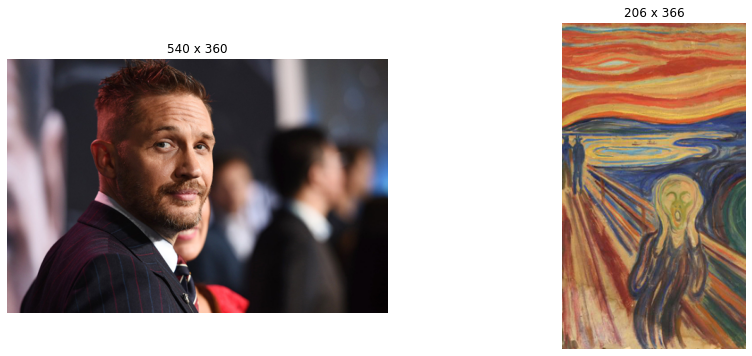

In [6]:
# Get content image and downsize it
content_image = Image.open(Path(data, "content.jpg")).convert('RGB')
content_image = content_image.resize((int(content_image.size[0]/3), int(content_image.size[1]/3)))
w_content, h_content = content_image.size

# Get content image and downsize it
style_image = Image.open(Path(data, "style.jpg")).convert('RGB')
style_image = style_image.resize((int(style_image.size[0]/2), int(style_image.size[1]/2)))
w_style, h_style = style_image.size

# Visualize
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title(f"{w_content} x {h_content}")
plt.imshow(content_image)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title(f"{w_style} x {h_style}")
plt.imshow(style_image)
plt.show()

# Content loss and Style loss

Given a **content image $p$** and a generated **white noise image $x$**, we examine the feature maps generated by the different convolutional layers of the pre-trained network VGG19. For the layer $l$, we denote $N_l$ the number of feature maps and $M_l$ their size (height $*$ weigth of the feature map). Thus, the responses of the layer $l$ for the image $P$ can be stored in a $N_l * M_l$ matrix $P^l$ where $P^l_{ij}$ is the activation of the $i^{th}$ filter at position $j$ in layer $l$. This matrix is referred to as the feature representation of the input image at layer $l$.

Given $P^l$ and $F^l$, the feature representations of respectively $p$ and $x$, the content loss is defined as $\frac{1}{2}\sum_{i,j}(F^l_{ij} - P^l_{ij})^2$.

The factor wl was always equal to one divided by the number of active layers
with a non-zero loss-weight wl

In [42]:
# in the tutorial the losses are defined as nn modules which is practical
# we can calculate the reference image loss in the init and the noise image loss 
# at each forward call
    
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean
        self.std = std
        
    def forward(self, input_tensor):
        normalized_tensor = (input_tensor - self.mean) / self.std
        return normalized_tensor
    
class ContentLoss(nn.Module):
    def __init__(self, ref_tensor):
        super(ContentLoss, self).__init__()
        self.ref_tensor = ref_tensor.detach()
    
    def forward(self, input_tensor):
        loss = F.mse_loss(self.ref_tensor, input_tensor)
        return loss
    
def get_gram_matrix(feature_maps):
    batch_size, n_feature_maps, h, w = feature_maps.size()
        
    # This transformation allows a direct inner prod without looping over feature maps
    features = feature_maps.view(batch_size * n_feature_maps, h * w)
        
    gram_matrix = torch.mm(features, features.t())  # compute the gram product
    gram_matrix = gram_matrix.div(batch_size * n_feature_maps * h * w)
        
    return gram_matrix
    
class StyleLoss(nn.Module):
    def __init__(self, ref_tensor):
        super(StyleLoss, self).__init__()
        self.ref_tensor = ref_tensor
        self.ref_gram = get_gram_matrix(self.ref_tensor).detach()
        
    def forward(self, input_tensor):
        input_gram = get_gram_matrix(input_tensor)
        loss = F.mse_loss(self.ref_gram, input_gram)
        return loss

# Reconstructions

Reconstruct images that match a given subnetworks output.

In [62]:
# Example with first conv 
model = conv5_1

content_tensor = image_to_tensor(content_image)
content_input = Normalization(CNN_NORM_MEAN, CNN_NORM_STD)(content_tensor)
content_output = model(content_input.unsqueeze(0))
content_loss = ContentLoss(content_output)

input_tensor = get_noise_tensor(content_image)
input_tensor.requires_grad_(True)
optimizer = optim.LBFGS([input_tensor])
n_iterations = 200
print_freq = 20

run = [0]
while run[0] <= (n_iterations):
            
    def closure():
                
        # correct the values of updated input image
        with torch.no_grad():
            input_tensor.clamp_(0, 1)
                    
        optimizer.zero_grad()
        input_norm= Normalization(CNN_NORM_MEAN, CNN_NORM_STD)(input_tensor)
        input_output = model(input_norm.unsqueeze(0))
        loss = content_loss(input_output)
        loss.backward()
                
        run[0] += 1
        if run[0] % print_freq == 0:
            print(f"Iteration {run[0]}: content loss = {loss.item()}")
        
        return loss
            
    optimizer.step(closure)

with torch.no_grad():
    input_tensor.clamp_(0, 1)

Iteration 20: content loss = 10.679783821105957
Iteration 40: content loss = 4.801268100738525
Iteration 60: content loss = 3.032562732696533
Iteration 80: content loss = 2.183067798614502
Iteration 100: content loss = 1.6966032981872559
Iteration 120: content loss = 1.3802086114883423
Iteration 140: content loss = 1.1505533456802368
Iteration 160: content loss = 0.9731315970420837
Iteration 180: content loss = 0.8370456099510193
Iteration 200: content loss = 0.7282164096832275
Iteration 220: content loss = 0.6384596824645996


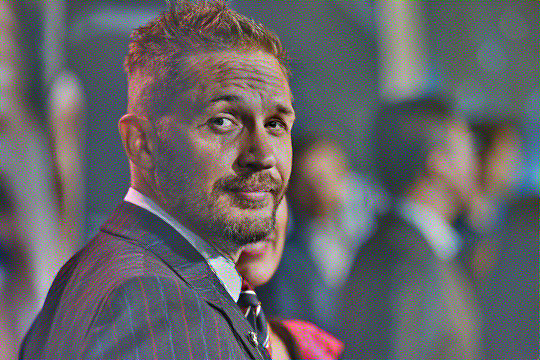

In [63]:
tensor_to_image(input_tensor)

In [74]:
# Example with first conv 
conv_models = [conv1_1]

style_losses = []
weight = 1 / len(conv_models)
for model in conv_models:
    style_tensor = image_to_tensor(style_image)
    style_input = Normalization(CNN_NORM_MEAN, CNN_NORM_STD)(style_tensor)
    style_output = model(style_input.unsqueeze(0))
    style_loss = StyleLoss(style_output)
    style_losses.append(style_loss)

input_tensor = get_noise_tensor(style_image)
input_tensor.requires_grad_(True)
optimizer = optim.LBFGS([input_tensor])
n_iterations = 100
print_freq = 10

run = [0]
while run[0] <= (n_iterations):
            
    def closure():
                
        # correct the values of updated input image
        with torch.no_grad():
            input_tensor.clamp_(0, 1)
                    
        optimizer.zero_grad()
        loss = 0
        for model, sloss in zip(conv_models, style_losses):
            input_norm = Normalization(CNN_NORM_MEAN, CNN_NORM_STD)(input_tensor)
            input_output = model(input_norm.unsqueeze(0))
            loss += weight * sloss(input_output)
        loss.backward()
                
        run[0] += 1
        if run[0] % print_freq == 0:
            print(f"Iteration {run[0]}: content loss = {loss.item()}")
        
        return loss
            
    optimizer.step(closure)

with torch.no_grad():
    input_tensor.clamp_(0, 1)

Iteration 10: content loss = 0.0008388488786295056
Iteration 20: content loss = 0.0008388488786295056
Iteration 30: content loss = 0.0008388488786295056
Iteration 40: content loss = 0.0008388488786295056
Iteration 50: content loss = 0.0008388488786295056
Iteration 60: content loss = 0.0008388488786295056
Iteration 70: content loss = 0.0008388488786295056
Iteration 80: content loss = 0.0008388488786295056
Iteration 90: content loss = 0.0008388488786295056
Iteration 100: content loss = 0.0008388488786295056


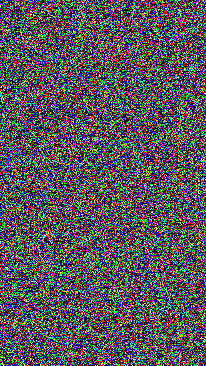

In [75]:
tensor_to_image(input_tensor)

In [75]:
class ContentReconstructor:
    
    def __init__(self, content_image, cnn_list = [conv1_1, conv2_1, conv3_1, conv4_1, conv5_1]):
        
        self.content_image = content_image
        self.content_tensor = get_normalized_tensor(content_image)
        self.cnn_list = cnn_list
        
    def reconstruct(self, n_iterations, cnn_idx, print_freq = 10):
        
        # Prepare input
        input_image = get_noise_image(self.content_image)
        input_tensor = image_to_tensor(input_image)
        input_tensor.requires_grad_(True)
        
        # Optimizer
        optimizer = optim.LBFGS([input_tensor], line_search_fn='strong_wolfe')
        
        # Content output
        cnn = self.cnn_list[cnn_idx]
        content_output = cnn(self.content_tensor)
        
        run = [0]
        while run[0] <= (n_iterations):
            
            def closure():
                
                # correct the values of updated input image
                with torch.no_grad():
                    input_tensor.clamp_(0, 1)
                    
                optimizer.zero_grad()
                norm_input_tensor = (input_tensor.unsqueeze(0) - CNN_NORM_MEAN) / CNN_NORM_STD
                loss = F.mse_loss(content_output, cnn(norm_input_tensor))
                loss.backward()
                
                run[0] += 1
                if run[0] % print_freq == 0:
                    print(f"Iteration {run[0]}: content loss = {loss.item()}")
        
                return loss
            
            optimizer.step(closure)
        return input_tensor.clamp(0, 1)
        
        
reconstructor = ContentReconstructor(content_image)
res = reconstructor.reconstruct(n_iterations=200, cnn_idx=4)
transforms.ToPILImage()((res).squeeze(0))

Iteration 10: content loss = 64.31258392333984
Iteration 20: content loss = 15.618847846984863
Iteration 30: content loss = 8.849356651306152
Iteration 40: content loss = 5.922276973724365
Iteration 50: content loss = 4.605183124542236
Iteration 60: content loss = 3.6982877254486084
Iteration 70: content loss = 3.1229636669158936
Iteration 80: content loss = 2.634627342224121
Iteration 90: content loss = 2.3126049041748047
Iteration 100: content loss = 2.03341007232666
Iteration 110: content loss = 1.8310153484344482
Iteration 120: content loss = 1.6484615802764893
Iteration 130: content loss = 1.4983577728271484
Iteration 140: content loss = 1.383074164390564
Iteration 150: content loss = 1.273166298866272
Iteration 160: content loss = 1.1874018907546997
Iteration 170: content loss = 1.103371500968933
Iteration 180: content loss = 1.0364999771118164
Iteration 190: content loss = 0.9694617390632629
Iteration 200: content loss = 0.9115346670150757
Iteration 210: content loss = 0.8535829

In [ ]:
class StyleReconstructor:
    
    def __init__(self, style_image, cnn_list = [conv1_1, conv2_1, conv3_1, conv4_1, conv5_1]):
        
        self.style_image = style_image
        self.style_tensor = get_normalized_tensor(style_image)
        self.cnn_list = cnn_list
                  
    @staticmethod
    def get_gram_matrix(feature_maps):
        batch_size, n_feature_maps, h, w = feature_maps.size()
        
        # This transformation allows a direct inner prod without looping over feature maps
        features = feature_maps.view(batch_size * n_feature_maps, h * w)
        
        gram_matrix = torch.mm(features, features.t())  # compute the gram product
        gram_matrix = gram_matrix.div(batch_size * n_feature_maps * h * w)
        
        return gram_matrix
    
    def reconstruct(self, n_iterations, cnn_idx, print_freq = 10):
        
        # Prepare input
        input_image = get_noise_image(self.content_image)
        input_tensor = transforms.ToTensor()(input_image)
        input_tensor.requires_grad_(True)
        
        # Optimizer
        optimizer = optim.LBFGS([input_tensor], line_search_fn='strong_wolfe')
        
        
        run = [0]
        while run[0] <= (n_iterations):
            
            def closure():
                
                optimizer.zero_grad()
                norm_input_tensor = (input_tensor.unsqueeze(0) - CNN_NORM_MEAN) / CNN_NORM_STD
                
                
                for cnn in self.cnn_list:
                    
                    # correct the values of updated input image
                    with torch.no_grad():
                        input_tensor.clamp_(0, 1)
                        output = cnn(norm_input_tensor)
                        
                    style_output = cnn(self.style_tensor)
                    style_gram = self.get_gram_matrix(style_output)
                
                
                gram = self.get_gram_matrix(output)
                
                loss = F.mse_loss(style_gram, gram)
                loss.backward()
                
                run[0] += 1
                if run[0] % print_freq == 0:
                    print(f"Iteration {run[0]}: content loss = {loss.item()}")
        
                return loss
            
            optimizer.step(closure)
        return input_tensor.clamp(0, 1)
        
        
reconstructor = ContentReconstructor(content_image)
res = reconstructor.reconstruct(n_iterations=200, cnn_idx=4)
transforms.ToPILImage()((res).squeeze(0))

In [18]:
class Reconstructor:
    
    def __init__(self, content_image, style_image, cnn_list = [conv1_1, conv2_1, conv3_1, conv4_1, conv5_1]):
        # Save images
        self.content_image = content_image
        self.style_image = style_image
        
        # Get normalized tensors
        self.content_tensor = get_normalized_tensor(content_image)
        self.style_tensor = get_normalized_tensor(style_image)
        
        self.cnn_list = cnn_list
        
    def reconstruct_content(self, conv_number, learning_rate, momentum = 0.95, n_iterations = 500, print_freq = 100):
        # Create noise input
        w_content, h_content = self.content_image.size
        tmp = get_noise_image(w_content, h_content)
        content_noise = Parameter(data = get_normalized_tensor(tmp))
        
        loss_function = F.mse_loss
        optimizer = optim.SGD([content_noise], lr=learning_rate, momentum=momentum)
        
        # Get network
        cnn = self.cnn_list[conv_number-1]
            
        # TODO which loop with min loss to reach ? 
        for it in range(n_iterations):
            
            optimizer.zero_grad()
            
            ref_response = cnn(self.content_tensor)
            cur_response = cnn(content_noise)
            
            loss = loss_function(cur_response, ref_response)
            loss.backward()
            
            optimizer.step()
            
            if it % print_freq == 0:
                print(f"Iteration {it}: content loss = {loss.item()}")
        
        print(f"Final loss = {loss.item()}")
        return content_noise.data
    
    @staticmethod
    def get_gram_matrix(feature_maps):
        batch_size, n_feature_maps, h, w = feature_maps.size()
        
        # This transformation allows a direct inner prod without looping over feature maps
        features = feature_maps.view(batch_size * n_feature_maps, h * w)
        
        gram_matrix = torch.mm(features, features.t())  # compute the gram product
        gram_matrix = gram_matrix.div(batch_size * n_feature_maps * h * w)
        
        return gram_matrix
            
    
    def reconstruct_style(self, max_conv_number, learning_rate, momentum = 0.95, n_iterations = 500, print_freq = 100):
        
        # Create noise input
        w_style, h_style = self.style_image.size
        weight = 1. / max_conv_number
        style_noise = Parameter(data = get_normalized_tensor(get_noise_image(w_style, h_style)))
        
        print(style_noise.min(), style_noise.max())
        loss_function = F.mse_loss
        optimizer = optim.LBFGS([style_noise])
        
        # TODO which loop with min loss to reach ? 
        for it in range(n_iterations):
            
            def closure():
                # correct the values of updated input image
                with torch.no_grad():
                    style_noise.clamp_(0, 1)

                optimizer.zero_grad()
                model(input_img)
                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss

                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)
            
            optimizer.zero_grad()
            total_loss = 0
            
            for cnn in self.cnn_list[:max_conv_number]:

                ref_response = cnn(self.style_tensor)
                cur_response = cnn(style_noise)

                ref_gram = self.get_gram_matrix(ref_response)
                cur_gram = self.get_gram_matrix(cur_response)

                loss = loss_function(cur_gram, ref_gram)
                total_loss += weight*loss

            total_loss.backward()
            optimizer.step()
                
            if it % print_freq == 0:
                print(f"Iteration {it}: content loss = {total_loss.item()}")
            
        print(f"Final loss = {total_loss.item()}")
        return style_noise.data

Testing

In [19]:
reconstructor = Reconstructor(content_image, style_image)
res = reconstructor.reconstruct_style(3, 20000,  n_iterations=300, print_freq=10)
get_unnormalized_image(res)

NameError: name 'content_img' is not defined

Iteration 0: content loss = 5.509171962738037
Iteration 50: content loss = 0.24565957486629486
Iteration 100: content loss = 0.017013225704431534
Iteration 150: content loss = 0.0012910593068227172
Final loss = 0.0001018341354210861


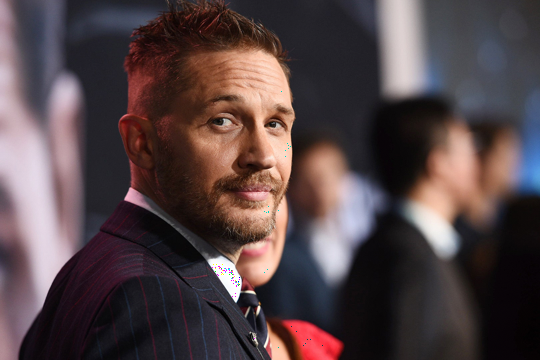

In [28]:
reconstructor = Reconstructor(content_image, style_image)
res = reconstructor.reconstruct_content(1, 10000,  n_iterations=200, print_freq=50)
get_unnormalized_image(res)

In [22]:
# Get content image and downsize it
content_img_tensor = get_normalized_tensor(content_img)

# Create random noise image of same dimensions
content_noise = get_noise_image(w_content, h_content)

In [6]:
# Run gradient descent
def reconstruct_content(input_tensor, 
                        reference_tensor, 
                        cnn, 
                        learning_rate,
                        n_iterations = 500,
                        print_freq = 100):
    
    input_params = Parameter(data = input_tensor)
    optimizer = optim.SGD([input_params], lr=learning_rate, momentum = 0.95)
    
    for iteration in range(n_iterations):
        
        optimizer.zero_grad()
        
        #  Get feature responses
        reference_response = sub_cnn(reference_tensor)
        current_response = sub_cnn(input_params)

        # Content loss
        loss = F.mse_loss(current_response, reference_response)
        loss.backward()

        if iteration % print_freq == 0:
            print(f"Iteration {iteration}: content loss = {loss.item()}")

        optimizer.step()
        
    print(f"Final loss = {loss.item()}")    
    return input_params.data

def get_gram_matrix(feature_maps):
    
    n_feature_maps = len(feature_maps)
    gram_matrix = torch.empty((n_feature_maps, n_feature_maps))
    
    for i in range(n_feature_maps):
        for j in range(n_feature_maps):
            ti = feature_maps[i]
            tj = feature_maps[j]
            gram_matrix[i, j] = torch.dot(ti, tj)
            
    return gram_matrix
            
    

def reconstruct_style(input_tensor, 
                        reference_tensor, 
                        cnn, 
                        learning_rate,
                        n_iterations = 500,
                        print_freq = 100):
    
    input_params = Parameter(data = input_tensor)
    optimizer = optim.SGD([input_params], lr=learning_rate, momentum = 0.95)
    
    for iteration in range(n_iterations):
        
        optimizer.zero_grad()
        
        #  Get feature responses
        reference_response = sub_cnn(reference_tensor)
        current_response = sub_cnn(input_params)

        # Content loss
        loss = F.mse_loss(current_response, reference_response)
        loss.backward()

        if iteration % print_freq == 0:
            print(f"Iteration {iteration}: content loss = {loss.item()}")

        optimizer.step()
        
    print(f"Final loss = {loss.item()}")    
    return input_params.data

In [ ]:
# Prepare noise image 
content_noise_tensor = get_normalized_tensor(content_noise)

# Get subsection of network with conv layer outputs
conv_layer_id = 5
layer_id = conv_dict[conv_layer_id]
sub_cnn = cnn[:layer_id]
output_file = f"data/conv{layer_id}_reconstruction.png"
learning_rate = 100
n_iterations = 500
print_freq = 10

# Reconstruct
content_noise_tensor = reconstruct_content(content_noise_tensor, 
                        content_img_tensor, 
                        sub_cnn, 
                        learning_rate,
                        n_iterations,
                        print_freq)

# Get image
res = get_unnormalized_image(content_noise_tensor)

# Save 
#res.save(output_file)
res

Iteration 0: content loss = 169.84378051757812
Iteration 10: content loss = 61.31689453125
Iteration 20: content loss = 46.663352966308594
Iteration 30: content loss = 31.397314071655273
Iteration 40: content loss = 21.119688034057617
Iteration 50: content loss = 14.685384750366211
Iteration 60: content loss = 10.473466873168945
Iteration 70: content loss = 7.704807281494141
Iteration 80: content loss = 5.831153392791748
Iteration 90: content loss = 4.5346999168396
Iteration 100: content loss = 3.6134934425354004
Iteration 110: content loss = 2.944903612136841
Iteration 120: content loss = 2.450686454772949
Iteration 130: content loss = 2.0812838077545166
Iteration 140: content loss = 1.8058069944381714
Iteration 150: content loss = 1.5932950973510742
Iteration 160: content loss = 1.424504280090332
Iteration 170: content loss = 1.2968462705612183
Iteration 180: content loss = 1.1927329301834106


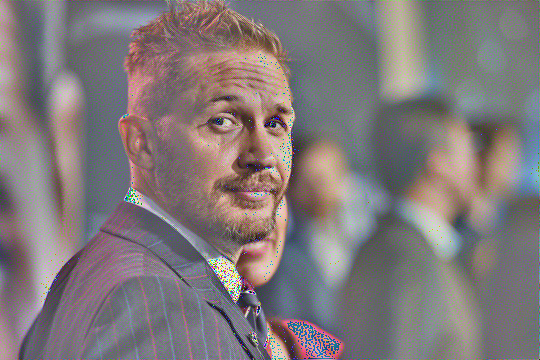

In [17]:
# Conv 4 : 1500 iterations with learning rate = 500, final loss = 0.63
res = transforms.ToPILImage()((content_noise_tensor * cnn_normalization_std + cnn_normalization_mean).squeeze(0))
res.save("data/conv4_reconstruction.png")
res

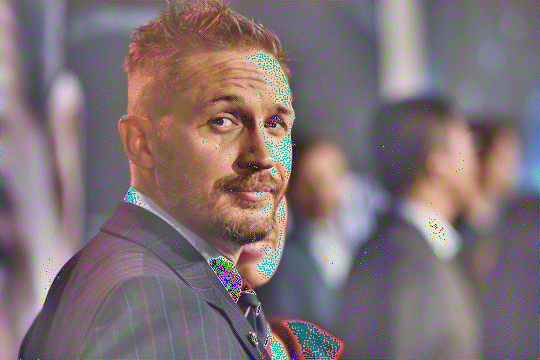

In [185]:
# Conv 3 : 1000 iterations with learning rate = 500, final loss = 4e-3
res = transforms.ToPILImage()((content_noise_tensor * cnn_normalization_std + cnn_normalization_mean).squeeze(0))
res.save("data/conv3_reconstruction.png")
res

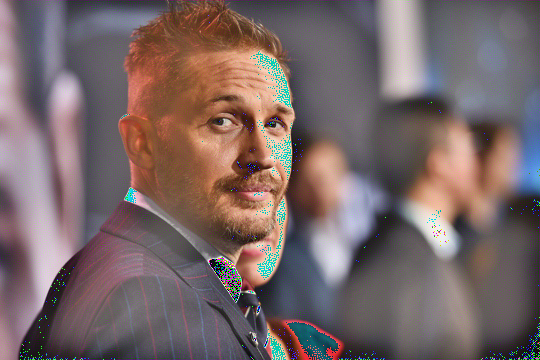

In [181]:
# Conv 2 : 1000 iterations with learning rate = 1000, final loss = 4e-3
res = transforms.ToPILImage()((content_noise_tensor * cnn_normalization_std + cnn_normalization_mean).squeeze(0))
res.save("data/conv2_reconstruction.png")
res

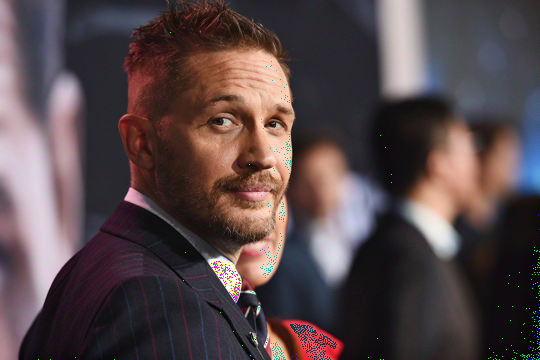

In [175]:
# Conv 1 : 500 iterations with learning rate = 10000, final loss = 1.2e-3
res = transforms.ToPILImage()((content_noise_tensor * cnn_normalization_std + cnn_normalization_mean).squeeze(0))
res.save("data/conv1_reconstruction.png")
res